# set path

In [487]:
import os
try:
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=False)
    rootpath = '/content/drive/My Drive/ai-side-projects/self-supervised-halos/data/freya_postprocess/'
except:
    %matplotlib inline
    rootpath = '/Users/sdbykov/work/self-supervised-halos/data/freya_postprocess/'
os.chdir(rootpath)

# Imports

In [488]:
import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torch.utils.data import TensorDataset, DataLoader



try:
    subhalos_df = pd.read_pickle(rootpath+'/subhalos_df.pkl')
except:
    subhalos_df = pd.read_pickle('/Users/sdbykov/work/self-supervised-halos/data/subhalos_df.pkl')
subhalos_df['logSubhaloMass'] = np.log10(subhalos_df['SubhaloMass']*1e10/0.6774)



# Data loaders and transformers

In [489]:

class HaloDataset(torch.utils.data.Dataset):
    mass_bins = np.linspace(11, 14.7, 11)

    def __init__(self, root_dir, load_3d = False):
        self.root_dir = root_dir
        
        self.files = glob(root_dir+'*.npz')
        self.halos_ids = [int(x.split('_')[-1].split('.')[0]) for x in self.files]

        self.load_3d = load_3d

    def __len__(self):
        return len(self.halos_ids)
    
    def __getitem__(self, idx):
        halo_id = self.halos_ids[idx]
        fname_root = f'{self.root_dir}halo_{halo_id}'

        data = np.load(fname_root+'.npz')
        data_xy = data['map_2d_xy']
    
        data_xz = data['map_2d_xz']
        data_yz = data['map_2d_yz']
        snap = data['snap']
        snap_mass = data['mass']
        data_3d = data['map_3d'] 


        #strikes for debugging angles of rotation
        # data_xy[:, 32] = np.max(data_xy)
        # data_xz[:16, 32] = np.max(data_xz)
        # data_xz[48:, 32] = np.max(data_xz)
        # data_yz[16:48, 32] = np.max(data_yz)


        label_mass = subhalos_df.loc[halo_id]['logSubhaloMass']
        label_class = np.digitize(label_mass, self.mass_bins)
        label = (label_mass, label_class)

        del data
        
        #make 2d data as 1 channel images
        data_xy = np.expand_dims(data_xy, axis=0)
        data_xz = np.expand_dims(data_xz, axis=0)
        data_yz = np.expand_dims(data_yz, axis=0)
        
        tuple_to_resuts = data_3d,(data_xy, data_xz, data_yz), (snap, snap_mass)

        return tuple_to_resuts, label
    

In [490]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
if device=='cuda':
    print(torch.cuda.get_device_properties(0).name)


cpu


In [491]:
dataset = HaloDataset(rootpath, load_3d = False)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True) 


In [492]:
class RandomRotationWithMinFill:
    def __init__(self, degrees):
        self.degrees = degrees

    def __call__(self, img):
        # Ensure the input is a tensor
        if not isinstance(img, torch.Tensor):
            raise TypeError("Input should be a tensor")

        # Get the minimum value of the original image
        min_val = img.min()
        #min_val = 0

        # Rotate the image
        angle = torch.empty(1).uniform_(-self.degrees, self.degrees).item()
        rotated_img = torchvision.transforms.functional.rotate(img, angle=angle)

        # Create a mask where the rotated image is zero
        mask = rotated_img == 0

        # Fill the masked area with the minimum value of the original image
        rotated_img[mask] = min_val

        return rotated_img


contrast_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.5, 0.95)),
    RandomRotationWithMinFill(degrees=180),
])


def select_views_and_transform_img(projections, transform = contrast_transforms):
    i1, i2 = np.random.choice(3, 2, replace=False) #TODO replace False or True? If True, then the same view can be selected twice
    view1 = projections[i1]
    view2 = projections[i2]

    view1 = transform(view1)
    view2 = transform(view2)

    return view1, view2

def select_views_and_transform(batch_projections, transform = contrast_transforms):
    transformed_batch_view1 = []
    transformed_batch_view2 = []
    #for projection in batch_projections:
    for i in range(len(batch_projections[0])):
        projection = [batch_projections[0][i], batch_projections[1][i], batch_projections[2][i]]
        transformed_example = select_views_and_transform_img(projection, transform)
        transformed_batch_view1.append(transformed_example[0])
        transformed_batch_view2.append(transformed_example[1])

    transformed_batch = torch.stack(transformed_batch_view1), torch.stack(transformed_batch_view2)

    return transformed_batch



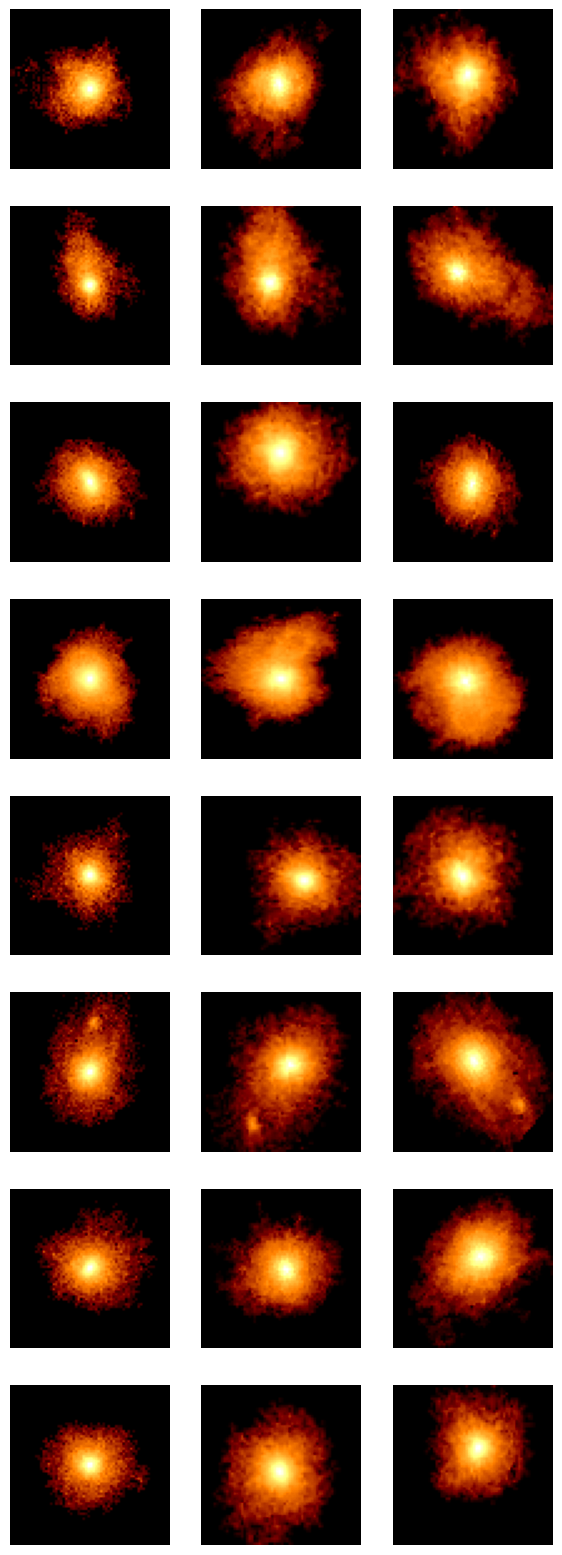

In [493]:
batch_data_full, batch_label = next(iter(dataloader))
batch_data = batch_data_full[1]

view1, view2 = select_views_and_transform(batch_data)
orig = batch_data[0]

fig, axs = plt.subplots(8, 3, figsize=(7, 20))

for i in range(8):
    axs[i, 0].imshow(orig[i][0].cpu().numpy(), cmap='afmhot')
    axs[i, 1].imshow(view1[i][0].cpu().numpy(), cmap='afmhot')
    axs[i, 2].imshow(view2[i][0].cpu().numpy(), cmap='afmhot')
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')
    axs[i, 2].axis('off')

# Contrastive loss

In [494]:

class SupConLoss(nn.Module): #TODO check/test this loss
    #src: https://github.com/giakoumoglou/classification/tree/main/notebooks
    #if no labels are provided, it is basically the SimCLRLoss #TODO check this with SimCLRLoss class
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07,
                 device = 'cpu'):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

        self.device = device

    def forward(self, features, labels=None, mask=None):

        device = self.device

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss



# Model

In [495]:
class Encoder(nn.Module):

    "Encoder network"
    def __init__(self):
        super(Encoder, self).__init__()
    
        image_channels = 1
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            #nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten()
        )

    def forward(self, x):
        return self.encoder(x)
    
class ProjectionHead(nn.Module):
    "Projection head"
    def __init__(self, input_dim=64, hidden_dim=128, output_dim=64):
        super(ProjectionHead, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.projection_head(x)
    

class SupCon(nn.Module):
    """encoder + projection head"""
    def __init__(self, encoder, head):
        super(SupCon, self).__init__()
        self.encoder = encoder
        self.head = head

    def forward(self, x):
        x = self.encoder(x)
        x = F.normalize(self.head(x), dim=1)
        return x


In [496]:
batch_size=32

limit_dataset = 500


dataset = HaloDataset(rootpath, load_3d = False)

if limit_dataset:
    dataset_tr = torch.utils.data.random_split(dataset, [limit_dataset, len(dataset)-limit_dataset])
    dataloader = DataLoader(dataset_tr[0], batch_size=batch_size, shuffle=True)

else:
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) 




In [497]:
lr = 1e-3
temperature = 0.07


encoder = Encoder().to(device)
head = ProjectionHead().to(device)
model = SupCon(encoder=encoder, head = head).to(device)

criterion = SupConLoss(temperature=temperature, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)


In [498]:
#debug shapes
batch_data_full, batch_label = next(iter(dataloader))
batch_data = batch_data_full[1]

output = model(batch_data[0].to(device))
output.shape

torch.Size([32, 64])

# Train step 

In [499]:
def supcon_train_step(
        epoch,
        model, 
        criterion,
        optimizer,
        scheduler,
        dataloader,
        history=None,
        device='cpu',
        ):
    
    model.train()

    running_loss = 0.0

    for i, (batch_data_full, batch_label) in enumerate(dataloader):
        batch_size = batch_label[0].shape[0]

        batch_data = batch_data_full[1]
        view1, view2 = select_views_and_transform(batch_data)
        view1 = view1.to(device)
        view2 = view2.to(device)

        stop = 1
        data = torch.cat([view1, view2], dim=0)
        data = data.to(device)

        features = model(data)

        f1, f2 = torch.split(features, [batch_size, batch_size], dim=0)
        features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)

        loss = criterion(features)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step() if scheduler is not None else None

        running_loss += loss.item()

    running_loss /= len(dataloader)
    print(f'Epoch {epoch}, loss: {running_loss}')

    if history is not None:
        history['loss'].append(running_loss)
    
    return running_loss


In [500]:
def supcon_train(epochs,
                 model,
                 criterion,
                 optimizer,
                 scheduler,
                 dataloader,
                 history=None,
                 device = 'cpu'):

    pbar = tqdm(range(epochs))

    history = {'loss': []}

    try:
        for epoch in pbar:
            loss = supcon_train_step(
                epoch,
                model, 
                criterion,
                optimizer,
                scheduler,
                dataloader,
                history=history,
                device=device
            )
            pbar.set_postfix({'loss': loss})

    except KeyboardInterrupt:
        print('Interrupted')
    
    return history

In [ ]:
n_epochs = 20

history = supcon_train(n_epochs, 
                       model,
                       criterion,
                       optimizer,
                       scheduler=scheduler,
                        dataloader=dataloader,
                        device=device)


---